In [2]:
import pickle
import numpy as np

import laika.raw_gnss as raw
from cereal import messaging
from laika import AstroDog, helpers
from laika.gps_time import GPSTime
from laika.raw_gnss import read_raw_ublox


In [4]:
from laika.raw_gnss import calc_pos_fix, calc_vel_fix, correct_measurements, group_measurements_by_epoch,  group_measurements_by_sat,  process_measurements

# Seems that we can have these sm messages:
#   "gpsLocationExternal"
#   "ubloxGnss"
#   "qcomGnss"
#   "ubloxRaw"
#   "liveLocationKalman"

# noinspection PyUnreachableCode

def process(ubloxGnss):
  # Can also be 'measurementReport', 'ephemeris', 'ionoData', 'hwStatus', 'hwStatus2'

  if ubloxGnss.which == 'measurementReport':
    report = ubloxGnss.measurementReport
#     print(ubloxGnss)
    # With internet: uses dog
    if len(report.measurements) > 0 and False:
      new_meas = read_raw_ublox(report)
      new_meas = [m for m in new_meas if helpers.get_constellation(m.prn) == 'GPS']
      measurements.extend(new_meas)
      process_measurements(measurements, dog)

      recv_time = GPSTime(report.gpsWeek, report.rcvTow)
      measurements_t.append(recv_time.as_datetime())


filename = 'run_200.pickle'
handle = open(filename, 'rb')
raw_replay = pickle.load(handle)

measurements = []
measurements_t = []
dog = AstroDog(valid_const=['GPS', 'GLONASS'])

for ublox in raw_replay['raw_ubloxGnss']:
  # print("processing")
  process(ublox)



In [33]:
from laika.raw_gnss import group_measurements_by_sat, process_measurements
from math import ceil

print("Grouping")
measurements_by_epoch = group_measurements_by_epoch(measurements)
measurements_by_satellite = group_measurements_by_sat(measurements)

proc_meas = []
pos_solutions, vel_solutions = [], []
corrected_measurements_by_epoch = []
for meas_epoch in measurements_by_epoch[::2]:
  processed = process_measurements(meas_epoch, dog)
  pos_fix = calc_pos_fix(processed)
  # can be none if less than 6 satellites
  if len(pos_fix) > 0:
    est_pos = pos_fix[0][:3]
    corrected = correct_measurements(meas_epoch, est_pos, dog)
    corrected_measurements_by_epoch.append(corrected)
    pos_solutions.append(calc_pos_fix(corrected))
    # you need an estimate position to calculate a velocity fix
    vel_solutions.append(calc_vel_fix(corrected, pos_solutions[-1][0]))

Grouping


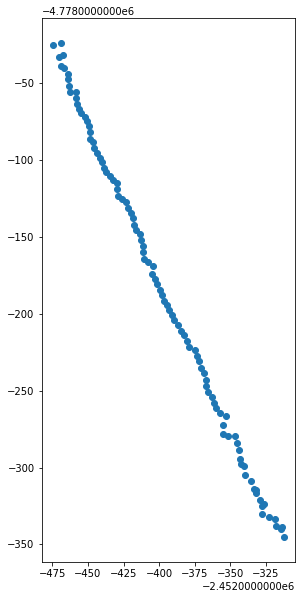

NameError: name 'sns' is not defined

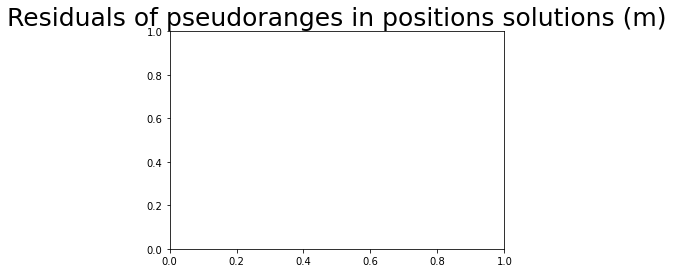

In [41]:

receiver_pos_solutions = np.zeros((len(pos_solutions), 3))
for i, p in enumerate(pos_solutions):
  receiver_pos_solutions[i] = p[0][:3]

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.scatter(receiver_pos_solutions[:, 0], receiver_pos_solutions[:, 1])
plt.show()
# print(pos_solutions[1])

plt.figure()
plt.title('Residuals of pseudoranges in positions solutions (m)', fontsize=25)
sns.histplot(np.concatenate([sol[1] for sol in pos_solutions]), bins=arange(-5, 5, .5), kde=False, stat="density", linewidth=0)
plt.xlim(-5, 5)
